# pisanie kodu do groupedStack plota

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"

In [3]:
df = pd.read_csv("./mock_data/mock_data.csv")

In [4]:
df

,sample_id,molecule1,molecule2,molecule3,bg,sg
0,1,125,32,16,lean,f
1,5,45,6,3,obese,m
2,9,118,15,8,obese,f
3,16,66,17,9,lean,m


In [5]:
def dfToRowFract(df: pd.DataFrame,
                 cols_bg_sg: [str] = ["bg", "sg"],
                 cols_vals: [str] = ["molecule1", "molecule2"],
                 percentage: bool = True):

    """
    transforms all the numbers in a df to fractions of rowSums (or percentages)

    Input:
    ---
    df - table to be transformed
    cols_bg_sg - name of columns with 'big' and 'small' groups
    cols_vals - name of columns with digits
    percentage - should y axis represent absolute values or pct (upto 100%)

    Output:
    ---
    new transformed table, each result is val1/colSum1 (optionally: *100)
    """

    df_means = df[cols_bg_sg + cols_vals].groupby(cols_bg_sg).mean().reset_index()

    rowSums: pd.Series = df_means.loc[:, cols_vals].sum(axis=1)
    fractions: pd.DataFrame = df_means.loc[:, cols_vals].divide(rowSums, axis=0)
    if percentage:
        fractions = fractions * 100

    result = pd.concat([df_means.loc[:, cols_bg_sg], fractions], axis=1)

    return result        

In [6]:
x = dfToRowFract(df=df, cols_vals=["molecule1", "molecule2", "molecule3"], percentage=False)
x

,bg,sg,molecule1,molecule2,molecule3
0,lean,f,0.722543,0.184971,0.092486
1,lean,m,0.717391,0.184783,0.097826
2,obese,f,0.836879,0.106383,0.056738
3,obese,m,0.833333,0.111111,0.055556


In [7]:
def draw_groupedStackPlot(
    tab_with_data: pd.DataFrame,
    col_big_group: str,
    col_small_group: str,
    cols_digits: [str],
    order_cols_digits: [str],
    colors_digits: [(float)],
    labels_digits: [str],
    percentage: bool,
    main_title: str,
    x_axis_title: str,
    y_axis_title: str,
    labels_bars: [str],
):

    """
    draws a stackbarplot (bars in absolute or percentage quota, one on another)

    Input:
    ---
    tab_with_data - df with data (like the one in mock_data.csv)
    col_big_group - name of col with 'big' group
    col_small_group - name of col with 'small' group
    cols_digits - name of cols with digits to (each col new stack layer)
    order_cols_digits - order in which cols of digits will be ploted (btm->top)
    colors_digits - colors of cols with digits (colors of stack layers)
    labels_digits - labels of stack layers to be used in legend
    percentage - should plot absolute values or percentages (sum=100%)
    main_title - main title displayed above the plot
    x_axis_title - title displayed below x axis
    y_axis_title - title displayed on left of the y axis
    labels_bars - labels displayed below the bars (no of bars = len(bg)*len(sg))

    Output:
    ---
    a graph (stacked barplot or stacked percentage plot) - mpl.axes object
    """

    tab_data: pd.DataFrame = tab_with_data.copy()
    tab_data = tab_data.loc[:, cols_digits + [col_big_group, col_small_group]]
    if percentage:
        tab_data = dfToRowFract(df=tab_data,
                                cols_bg_sg=[col_big_group, col_small_group],
                                cols_vals=cols_digits,
                                percentage=percentage)

    maxVal: float = tab_data.sum(axis=1).max()

    plt.grid(
        b=True,
        linestyle="dashed",
        which="major",
        alpha=0.6,
        axis="y",
        color="grey",
        dashes=(5, 2),
        zorder=0,
    )

    lenBg: int = len(tab_with_data.loc[:, col_big_group].unique())
    lenSg: int = len(tab_with_data.loc[:, col_small_group].unique())
    noOfBars: int = lenBg * lenSg

    bar_width: float = 0.5/lenSg
    half_way: float = bar_width*lenSg/4
    x_pos: [int] = [np.linspace(start=i-half_way, stop=i+half_way, num=lenSg)
                    for i in range(lenBg)]
    x_pos = list(np.concatenate(x_pos))

    bottoms: [float] = [0] * noOfBars

    for i in (range(len(order_cols_digits))):

        heights = list(tab_data.loc[:, order_cols_digits[i]])
        plt.bar(
            x=x_pos,
            height=heights,
            bottom=bottoms,
            color=colors_digits[i],
            edgecolor="black",
            width=bar_width,
            zorder=2,
        )

        bottoms = list(map(lambda x, y: x + y, bottoms, heights))

    axes = plt.gca()
    axes.set_ylim([0, maxVal * 1.3])
    axes.set_xlim([x_pos[0]-bar_width, x_pos[-1]+bar_width])

    handles1: [mpatches.Patch] = []
    for i in range(len(order_cols_digits)):
        handles1.append(
            mpatches.Patch(
                edgecolor="black",
                linewidth=2,
                facecolor=colors_digits[i],
                label=labels_digits[i],
            )
        )

    plt.legend(handles=handles1, loc="best")

    plt.title(label=main_title)
    plt.xlabel(xlabel=x_axis_title)
    plt.ylabel(ylabel=y_axis_title)
    plt.xticks(ticks=x_pos, labels=labels_bars)

    # return 0

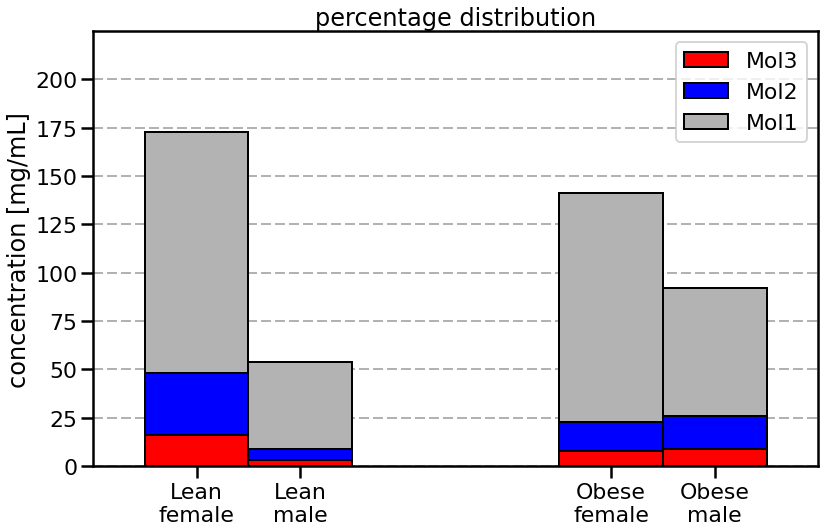

In [8]:
sns.set_context(context="poster")
plt.figure(figsize=(13, 8))
draw_groupedStackPlot(tab_with_data=df,
                      col_big_group="bg",
                      col_small_group="sg",
                      cols_digits=["molecule1", "molecule2", "molecule3"],
                      order_cols_digits=["molecule3", "molecule2", "molecule1"],
                      labels_digits=["Mol3", "Mol2", "Mol1"],
                      colors_digits=[(1, 0, 0), (0, 0, 1), (0.7, 0.7, 0.7)],
                      percentage=False,
                      main_title="percentage distribution",
                      y_axis_title="concentration [mg/mL]",
                      x_axis_title="",
                      labels_bars=["Lean\nfemale", "Lean\nmale",
                                   "Obese\nfemale", "Obese\nmale"])